In [1]:
!pip install yfinance pandas numpy matplotlib


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install yfinance pandas


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import yfinance as yf
import pandas as pd

# Download daily data for NIFTY50 (^NSEI) from 2022-01-01 to 2024-12-31
data = yf.download("^NSEI", start="2022-01-01", end="2024-12-31", interval="1d")
data = data.dropna()  # Remove rows with missing values
data.reset_index(inplace=True)  # Make 'Date' a column instead of index

# If columns are multi-index (which can happen), flatten them:
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

print(data.head())  # Show the first few rows
print(data.columns.tolist())  # Show column names


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price       Date         Close          High           Low          Open  \
0     2022-01-03  17625.699219  17646.650391  17383.300781  17387.150391   
1     2022-01-04  17805.250000  17827.599609  17593.550781  17681.400391   
2     2022-01-05  17925.250000  17944.699219  17748.849609  17820.099609   
3     2022-01-06  17745.900391  17797.949219  17655.550781  17768.500000   
4     2022-01-07  17812.699219  17905.000000  17704.550781  17797.599609   

Price  Volume  
0      200500  
1      247400  
2      251500  
3      236500  
4      239300  
['Date', 'Close', 'High', 'Low', 'Open', 'Volume']


In [4]:
data.to_csv("nifty50_yahoo_data.csv", index=False)
print("Dataset saved as nifty50_yahoo_data.csv")


Dataset saved as nifty50_yahoo_data.csv


In [5]:

import numpy as np
import matplotlib.pyplot as plt

# Load your dataset with signals
df = pd.read_csv("nifty50_with_indicators.csv")


In [10]:
def bollinger_band_signal(df):
    df['BB_Signal'] = 0
    df.loc[df['Close'] < df['BB_Lower'], 'BB_Signal'] = 1
    df.loc[df['Close'] > df['BB_Upper'], 'BB_Signal'] = -1
    return df

df = bollinger_band_signal(df)


In [11]:
print(df.columns.tolist())


['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'EMA_fast', 'EMA_slow', 'MACD', 'MACD_Signal', 'Low_Min', 'High_Max', '%K', '%D', 'TP', 'Cumulative_TP_Volume', 'Cumulative_Volume', 'VWAP', 'RSI', 'H-L', 'H-PC', 'L-PC', 'TR', 'ATR', 'BB_Signal']


In [12]:
# Initial capital and tracking variables
initial_capital = 1000  # INR
capital = initial_capital
position = 0  # 0: no position, 1: long, -1: short
entry_price = 0
portfolio = []
trade_log = []

# Trade parameters
take_profit = 0.05        # 5% take profit
stop_loss = 0.02          # 2% stop loss
trailing_stop = 0.015     # 1.5% trailing stop (for long)
max_short_days = 5        # Max holding period for short trades

# For drawdown tracking
max_portfolio = initial_capital
drawdowns = []
trade_open_day = None
trailing_stop_price = None


In [13]:
for i in range(len(df)):
    price = df.loc[i, 'Close']
    date = df.loc[i, 'Date']
    signal = df.loc[i, 'BB_Signal']  # Example: use BB_Signal, change as needed

    # If not in a trade
    if position == 0:
        if signal == 1:
            position = 1
            entry_price = price
            trade_open_day = i
            trailing_stop_price = price * (1 - trailing_stop)
            trade_log.append({'type': 'long', 'entry_date': date, 'entry_price': price})
        elif signal == -1:
            position = -1
            entry_price = price
            trade_open_day = i
            trade_log.append({'type': 'short', 'entry_date': date, 'entry_price': price})

    # If in a long trade
    elif position == 1:
        # Update trailing stop if new high
        if price * (1 - trailing_stop) > trailing_stop_price:
            trailing_stop_price = price * (1 - trailing_stop)
        # Take profit
        if price >= entry_price * (1 + take_profit):
            capital = capital * (price / entry_price)
            trade_log[-1].update({'exit_date': date, 'exit_price': price, 'result': 'win'})
            position = 0
        # Stop loss or trailing stop
        elif price <= min(entry_price * (1 - stop_loss), trailing_stop_price):
            capital = capital * (price / entry_price)
            trade_log[-1].update({'exit_date': date, 'exit_price': price, 'result': 'loss'})
            position = 0

    # If in a short trade
    elif position == -1:
        # Take profit
        if price <= entry_price * (1 - take_profit):
            capital = capital * (2 - price / entry_price)
            trade_log[-1].update({'exit_date': date, 'exit_price': price, 'result': 'win'})
            position = 0
        # Stop loss
        elif price >= entry_price * (1 + stop_loss):
            capital = capital * (2 - price / entry_price)
            trade_log[-1].update({'exit_date': date, 'exit_price': price, 'result': 'loss'})
            position = 0
        # Max 5 days holding for shorts
        elif i - trade_open_day >= max_short_days:
            capital = capital * (2 - price / entry_price)
            trade_log[-1].update({'exit_date': date, 'exit_price': price, 'result': 'timeout'})
            position = 0

    portfolio.append(capital)
    max_portfolio = max(max_portfolio, capital)
    drawdowns.append((max_portfolio - capital) / max_portfolio)


In [14]:
# Close any open trade at the last price
if position != 0:
    price = df.loc[len(df)-1, 'Close']
    date = df.loc[len(df)-1, 'Date']
    if position == 1:
        capital = capital * (price / entry_price)
        trade_log[-1].update({'exit_date': date, 'exit_price': price, 'result': 'close'})
    elif position == -1:
        capital = capital * (2 - price / entry_price)
        trade_log[-1].update({'exit_date': date, 'exit_price': price, 'result': 'close'})
    portfolio[-1] = capital


In [15]:
df['Portfolio'] = portfolio
df['Drawdown'] = drawdowns


In [16]:
# To see all trades
trade_log


[{'type': 'long',
  'entry_date': '2022-02-24',
  'entry_price': np.float64(16247.9501953125),
  'exit_date': '2022-03-07',
  'exit_price': np.float64(15863.150390625),
  'result': 'loss'},
 {'type': 'long',
  'entry_date': '2022-05-06',
  'entry_price': np.float64(16411.25),
  'exit_date': '2022-05-12',
  'exit_price': np.float64(15808.0),
  'result': 'loss'},
 {'type': 'long',
  'entry_date': '2022-06-13',
  'entry_price': np.float64(15774.400390625),
  'exit_date': '2022-06-16',
  'exit_price': np.float64(15360.599609375),
  'result': 'loss'},
 {'type': 'long',
  'entry_date': '2022-06-17',
  'entry_price': np.float64(15293.5),
  'exit_date': '2022-07-07',
  'exit_price': np.float64(16132.900390625),
  'result': 'win'},
 {'type': 'short',
  'entry_date': '2022-07-08',
  'entry_price': np.float64(16220.599609375),
  'exit_date': '2022-07-15',
  'exit_price': np.float64(16049.2001953125),
  'result': 'timeout'},
 {'type': 'short',
  'entry_date': '2022-07-20',
  'entry_price': np.floa

In [17]:
# Trade statistics
total_trades = len([t for t in trade_log if 'exit_price' in t])
winning_trades = len([t for t in trade_log if t.get('result') == 'win'])
losing_trades = len([t for t in trade_log if t.get('result') == 'loss'])
timeout_trades = len([t for t in trade_log if t.get('result') == 'timeout'])
close_trades = len([t for t in trade_log if t.get('result') == 'close'])

# Cumulative return
cumulative_return = (capital - initial_capital) / initial_capital * 100

# Sharpe ratio (assume risk-free rate = 0)
returns = pd.Series(portfolio).pct_change().dropna()
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0

# Max drawdown
max_drawdown = max(drawdowns) * 100

print(f"Final Portfolio Value: {capital:.2f} INR")
print(f"Cumulative Return: {cumulative_return:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}%")
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades}")
print(f"Losing Trades: {losing_trades}")
print(f"Timeout/Closed Trades: {timeout_trades + close_trades}")
print(f"Winning + Losing + Timeout/Closed = {winning_trades + losing_trades + timeout_trades + close_trades}")


Final Portfolio Value: 1110.89 INR
Cumulative Return: 11.09%
Sharpe Ratio: 0.45
Max Drawdown: 11.67%
Total Trades: 28
Winning Trades: 5
Losing Trades: 7
Timeout/Closed Trades: 16
Winning + Losing + Timeout/Closed = 28


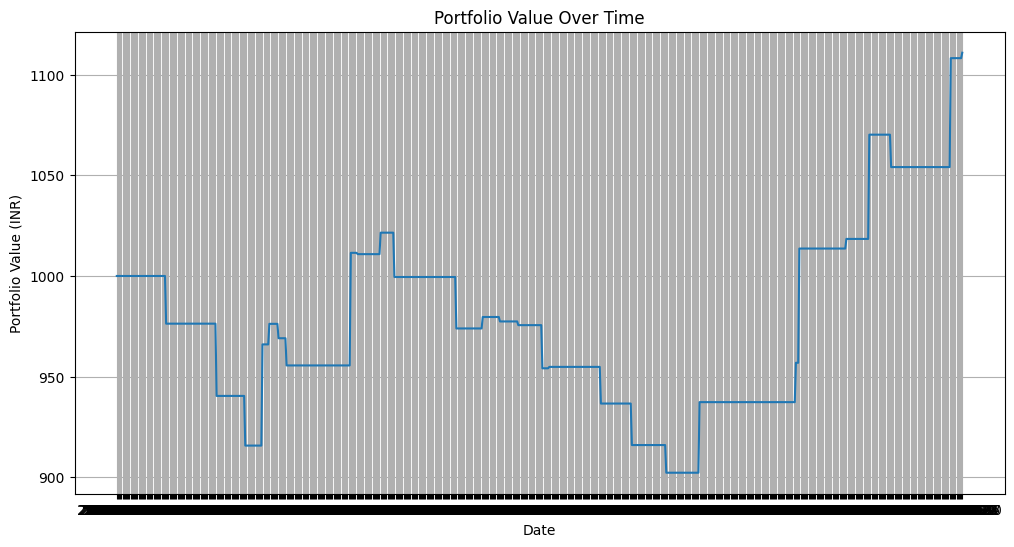

In [18]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Portfolio'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.grid()
plt.show()


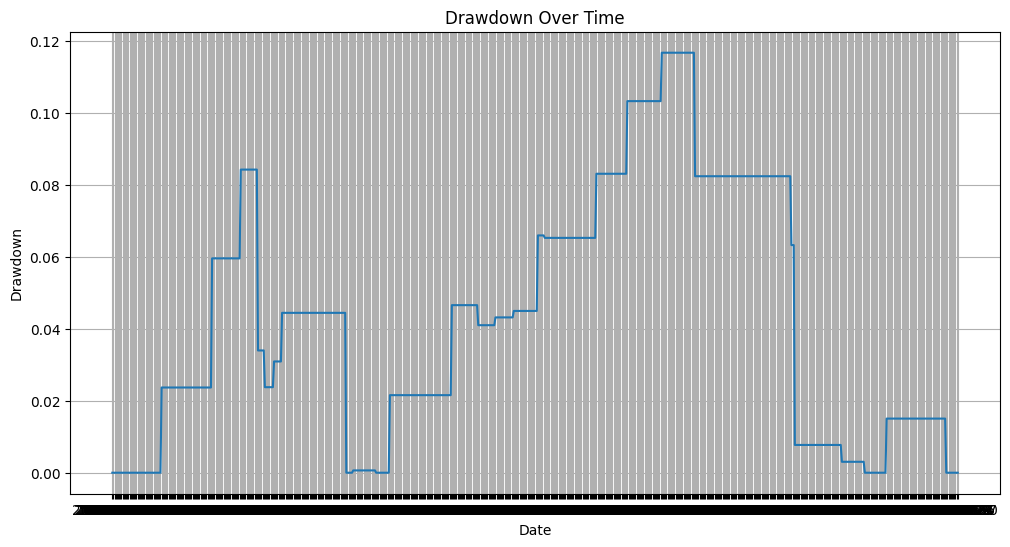

In [19]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Drawdown'])
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid()
plt.show()


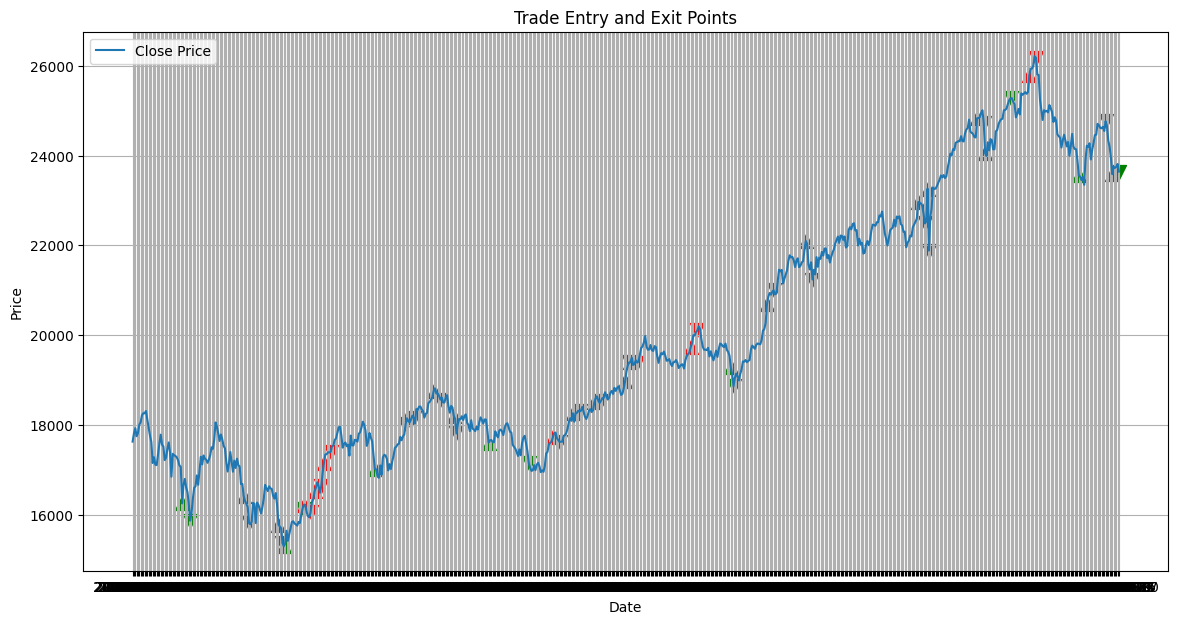

In [20]:
plt.figure(figsize=(14,7))
plt.plot(df['Date'], df['Close'], label='Close Price')
for t in trade_log:
    if 'exit_date' in t:
        entry_idx = df.index[df['Date'] == t['entry_date']][0]
        exit_idx = df.index[df['Date'] == t['exit_date']][0]
        color = 'g' if t['type'] == 'long' else 'r'
        plt.scatter(df.loc[entry_idx, 'Date'], df.loc[entry_idx, 'Close'], marker='^', color=color, s=100)
        plt.scatter(df.loc[exit_idx, 'Date'], df.loc[exit_idx, 'Close'], marker='v', color=color, s=100)
plt.title('Trade Entry and Exit Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
